In [1]:

import time
import warnings

from copy import deepcopy


from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from itertools import cycle, islice

import timeit
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
adata = sc.read_10x_mtx(
    'C:/Users/Computer/Desktop/pbmc3k_filtered_gene_bc_matrices.tar/pbmc3k_filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)   

x = adata._X.todense()
x.shape #shape of the data

(2700, 32738)

# Principal Component Analysis and Data cleanup
### 1. Basic Filtering:
1. Filter out the cells that express less than 200 genes 
1. Filter out genes that are expressed in less than 3 cells

### 2. mitochondrial DNA:

the value of the ratio of mitochondrial DNA and cellular RNA shows how high or low the quality of a cell is. The higher the proportion of mtDNA, the lower the quality of the data. From a biological point of view, more mitochondrial DNA shows that from a e.g. damaged cell, more "normal" RNA could be lost through perforations, while the larger mtDNA stays in the cell.

   1. calculate the ratio of mtDNA and RNA
   1. filter out cells with too high percentages


In [2]:
sc.pp.filter_cells(adata,min_genes=200)#filter cells with minimum 200 expressed genes
sc.pp.filter_genes(adata,min_cells=3) #filter genes with at least 3 cells the genes are expressed in
adata

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [3]:
# das Verhältnis zwischen normaler RNA und mitochondrialer DNA sagt etwas über die Integrität der Zellen aus: 
# Wenn zu viel mtDNA vorhanden ist, dann ist die Zelle wahrscheinlich beschädigt
#daher filtern wir die Zellen raus, in denen das Verhältnis verschoben ist
mtgenes = adata.var_names.str.startswith('MT-')
# das Verhältnis zwischen der mtDNA und der RNA muss berechnet werden
print(mtgenes)

[False False False ... False False False]


In [5]:
adata.obs['mito_percent'] = np.sum(adata[:,mtgenes].X, axis = 1).A1/np.sum(adata.X, axis = 1).A1
adata.obs['n_counts']=adata.X.sum(axis=1).A1

In [6]:
#the elimination 
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['mito_percent'] < 0.05, :]

In [7]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [8]:
sc.pp.log1p(adata)

In [9]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [10]:
adata = adata[:, adata.var['highly_variable']]

In [11]:
adata.shape

(2638, 1838)

In [12]:
array1 = np.array(x)

In [13]:
pca=PCA(n_components=10)
pca1=pca.fit_transform(array1)
pca1.shape

(2700, 10)

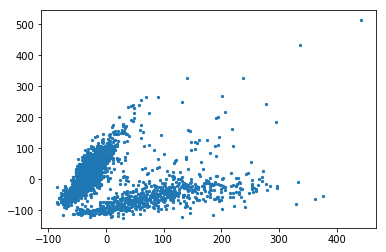

In [14]:
plt.scatter(pca1[:,0], pca1[:,1], s = 5)

In [20]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)
X_data = np.array(pca1)
n_samples=1000


k=2
  
Indecies_centroid = np.random.choice(n_samples,size=k) 
    
C=X_data[Indecies_centroid]

plt.scatter(X[:,0],X[:,1],c='black',s=7)
plt.scatter(C[:, 0], C[:, 1],marker='*',c='red',s=100)
    
clusters = np.zeros(len(X))
C_old = np.zeros(C.shape)
update_centroids = dist(C, C_old) # Konvergenz

while update_centroids.all() != 0:
    for i in range(len(X)):
            distances = dist(C,[X[i]])
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C)
    for i in range(k):
        points = [X[j] for j in range(len(X)) if clusters[j] == i]
        C[i] = np.mean(points, axis=0)
    update_centroids = dist(C, C_old)
        
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7)
ax.scatter(C[:, 0], C[:, 1], marker='*', c='black', s=100)

In [21]:
C2 = np.random.random((1,2))


# distance calculator
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)
   
clusters = np.zeros(len(X_data))
C_old = np.zeros(C2.shape)
error = dist(C2, C_old) 

data_2 = pd.DataFrame(X_data)
data_long = data_2.reset_index().melt(id_vars="index") 
a = np.array(data_long)
index =a[0:n_samples,0] 
Liste =[] 


k=3 #Anzahl der Cluster festlegen
n=0

while n<=k:
    n=n+1
    Liste =[]
    for i in range (len(X_data)):
        diff=X_data[i]-C2
        dist = np.linalg.norm(diff,axis=1) 
        min_dist= np.min(dist)
        Liste.append(min_dist)
    s= np.array(Liste)
    dist_2 = (s)**2
    prob = (dist_2)/ sum (dist_2) 
    z=np.random.choice(index, p=prob) 
    c_neu=X_data[z] 
    cl = np.ndarray.tolist(C) 
    c_neul = np.ndarray.tolist (c_neu) 
    cl.append (c_neul) 
    C2 = np.array(cl) 
    
while error.all() != 0:
    for i in range(len(X_data)):
            diff2=X_data[i]-C2
            distances = np.linalg.norm(diff2,axis=1) # Distance berechnen
            cluster = np.argmin(distances)
            clusters[i] = cluster
    C_old = deepcopy(C2)
    for i in range(k):
        points = [X_data[j] for j in range(len(X_data)) if clusters[j] == i]
        C2[i] = np.mean(points, axis=0)
    diff3 = C2-C_old
    error = np.linalg.norm(diff3,axis=1) # Distance berechnen
        

   
colors = ['r', 'g', 'b', 'y', 'c', 'm']
fig, ax = plt.subplots()
for i in range(k):
        points = np.array([X_data[j] for j in range(len(X_data)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i])
plt.scatter(cx1,cy1,marker='*',c='red',s=100)

ValueError: operands could not be broadcast together with shapes (10,) (1,2) 